In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Denoising Signal

1. $$ sin(t) + \epsilon $$
2. $$ \sum^{n}{a sin(bt + c)} + \epsilon $$
3. $$ e^{-t} cos(2\pi t) + \epsilon $$

## Data generation

### Data 1

In [3]:
block_size = 128

n_in = 1
n_sample = 51200
# n_sample = 16

In [4]:
# generate pure and noised sine signal
randomstart = np.random.normal(0, 2 * np.pi, n_sample)
sin_x = np.linspace(randomstart, randomstart + 4 * np.pi, num=block_size).T
pure_sin = np.sin(sin_x)
noisy_sin = pure_sin + 0.1 * np.random.randn(pure_sin.shape[1])

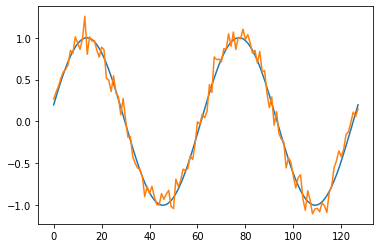

In [5]:
plt.plot(range(block_size), pure_sin[0])
plt.plot(range(block_size), noisy_sin[0])

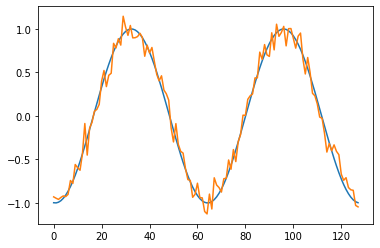

In [6]:
plt.plot(range(block_size), pure_sin[10])
plt.plot(range(block_size), noisy_sin[10])

In [7]:
class SinDataset(Dataset):
    
    def __init__(self, x, y, block_size):
        self.block_size = block_size
        self.x = x # noisy_sin
        self.y = y # pure_sin
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float)
        y = torch.tensor(self.y[idx], dtype=torch.float)
        return x, y
    
    def __len__(self):
        return len(self.x)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(noisy_sin, pure_sin, test_size=0.2,
                                                    shuffle=True, random_state=34)
train_dataset1 = SinDataset(x_train, y_train, block_size)
test_dataset1 = SinDataset(x_test, y_test, block_size)

In [9]:
x_train.size

5242880

### Data 2

In [10]:
start = np.zeros(n_sample)
sin_x = np.linspace(start -2 * np.pi, start + 2 * np.pi, num=block_size).T
pure_sin = np.sin(sin_x)
noisy_sin = pure_sin + 0.1 * np.random.randn(pure_sin.shape[1])
pure_sin.shape

(51200, 128)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(noisy_sin, pure_sin, test_size=0.2,
                                                    shuffle=True, random_state=34)
train_dataset2 = SinDataset(x_train, y_train, block_size)
test_dataset2 = SinDataset(x_test, y_test, block_size)

## Model

In [12]:
from model import TAE, TAEConfig
mconf = TAEConfig(n_in, block_size,
                 n_layer=2, n_head=4, n_embd=256)
model = TAE(mconf)

07/28/2021 00:54:50 - INFO - model - number of parameters: 3.688192e+06


In [13]:
import gc
gc.collect()

20

In [14]:
from pathlib import Path

PATH = Path("model")
FILENAME = "first_draft" + ".ckpt"
ckpt_path = PATH / FILENAME
# ckpt_path = None
if ckpt_path is not None and ckpt_path.exists():
    model.load_state_dict(torch.load(ckpt_path))

## Training

In [26]:
from trainer import Trainer, TrainerConfig
tconf = TrainerConfig(max_epochs=10, batch_size=128, learning_rate=6e-4,
                     lr_decay = True, ckpt_path=ckpt_path,
                     num_workers=2)
trainer = Trainer(model, train_dataset2, None, tconf)
trainer.train()

epoch 1 iter 319: train loss 0.00177. lr 6.000000e-04: 100%|██████████| 320/320 [01:50<00:00,  2.90it/s]
07/28/2021 01:03:16 - INFO - trainer - saving model/first_draft.ckpt
epoch 2 iter 319: train loss 0.00115. lr 5.853170e-04: 100%|██████████| 320/320 [02:02<00:00,  2.61it/s]
07/28/2021 01:05:19 - INFO - trainer - saving model/first_draft.ckpt
epoch 3 iter 319: train loss 0.00082. lr 5.427051e-04: 100%|██████████| 320/320 [02:03<00:00,  2.60it/s]
07/28/2021 01:07:22 - INFO - trainer - saving model/first_draft.ckpt
epoch 4 iter 319: train loss 0.00069. lr 4.763356e-04: 100%|██████████| 320/320 [02:03<00:00,  2.59it/s]
07/28/2021 01:09:26 - INFO - trainer - saving model/first_draft.ckpt
epoch 5 iter 319: train loss 0.00056. lr 3.927051e-04: 100%|██████████| 320/320 [02:04<00:00,  2.57it/s]
07/28/2021 01:11:30 - INFO - trainer - saving model/first_draft.ckpt
epoch 6 iter 319: train loss 0.00052. lr 3.000000e-04: 100%|██████████| 320/320 [02:04<00:00,  2.57it/s]
07/28/2021 01:13:35 - INF

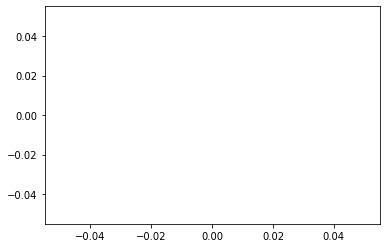

In [27]:
plt.plot(range(len(trainer.losses)), trainer.losses)

## Testing

In [28]:
from utils import sample

x = torch.tensor(noisy_sin[0], dtype=torch.float).to(trainer.device).view(1, block_size)
y = sample(model, x, 2000, temperature=1.0, sample=True, top_k=10)[0]
y = y.cpu().numpy()

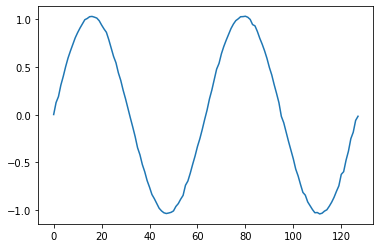

In [29]:
plt.plot(range(len(y)), y)

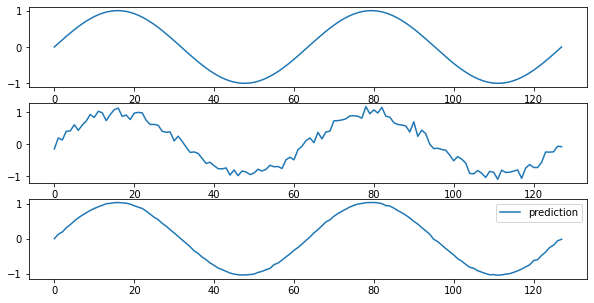

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(311)
plt.plot(range(block_size), pure_sin[0], label='pure')
plt.subplot(312)
plt.plot(range(block_size), noisy_sin[0], label='noisy')
plt.subplot(313)
plt.plot(range(len(y)), y, label='prediction')
plt.legend()
plt.show()

In [32]:
print(np.sum((pure_sin[0] - noisy_sin[0]) ** 2))
print(np.sum((pure_sin[0] - y.reshape(-1)) ** 2))

1.5020060929021026
0.10044167444977051
